## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# 1. Preparation

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# we are setting first column as index because its datetime column
df = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


## Resampling

In [4]:
data = df.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


# 2. Analysis

## Rolling Mean

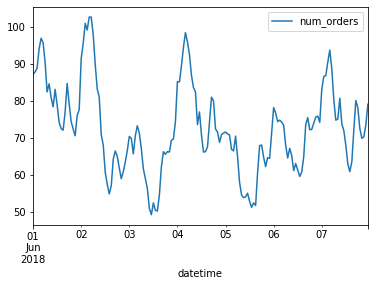

In [6]:
data.rolling(10).mean()['2018-06-01':'2018-06-7'].plot()

## Trends and Seasonality

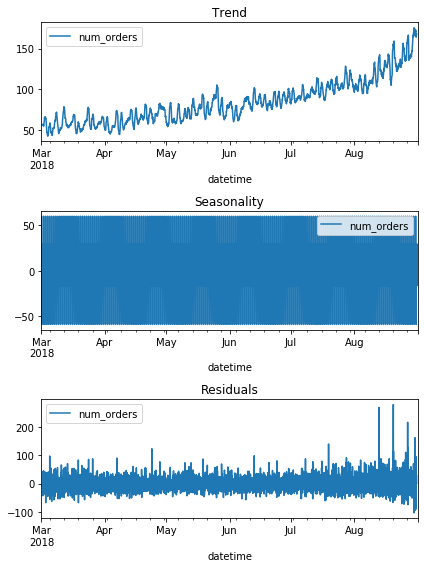

In [7]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

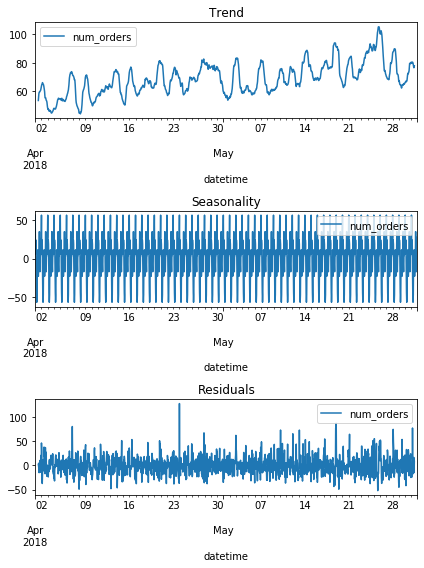

In [8]:
decomposed = seasonal_decompose(data['2018-04':'2018-05'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**From the graphs we can say that the thread increases overtime.**

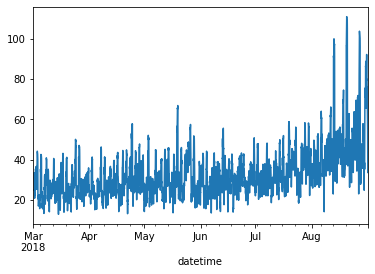

In [9]:
data['num_orders'].rolling(15).std().plot()

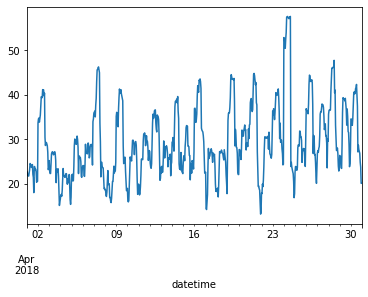

In [10]:
data['num_orders'].rolling(15).std()['2018-04':'2018-04'].plot()

In [11]:
##data = data['2018-04':'2018-05'].resample('1D').sum()
##decomposed = seasonal_decompose(data)
#plt.figure(figsize=(6, 8))
#plt.subplot(311)
# axes ax equal to plt.gca() (gca = get current axis)
#decomposed.trend['2018-04-01':'2018-04-15'].plot(ax=plt.gca())
#plt.title('Trend')
#plt.subplot(312)
#decomposed.seasonal['2018-04-01':'2018-04-15'].plot(ax=plt.gca())
#plt.title('Seasonality')
#plt.subplot(313)
#decomposed.resid['2018-04-01':'2018-04-15'].plot(ax=plt.gca())
#plt.title('Residuals')
#plt.tight_layout()

**The distribution does change, so the stochastic process is nonstationary**

# 3. Training

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features(data, 6, 6)

In [14]:
data.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


In [15]:
print("Before",len(data))
data = data.dropna()
print("After",len(data))

Before 4416
After 4410


In [16]:
features = data.drop(columns=['num_orders'])
target = data['num_orders']

In [17]:
full_train_X, test_X, full_train_y, test_y = train_test_split(features, target, shuffle=False, test_size=0.1)
train_X, valid_X, train_y, valid_y = train_test_split(full_train_X, full_train_y, shuffle=False, test_size=0.1)
print("Trainset Size", len(train_X), "Validation set Size", len(valid_X), "Test Size", len(test_X))

Trainset Size 3572 Validation set Size 397 Test Size 441


## Baseline Model

In [18]:
# using median
#pred_base = np.ones(test_y.shape)*full_train_y.median()
#np.sqrt(mean_squared_error(pred_base, test_y))

In [19]:
#using mean
pred_base = np.ones(test_y.shape)*full_train_y.mean()
np.sqrt(mean_squared_error(pred_base, test_y))

84.8147211664925

In [20]:
pred_previous = test_y.shift()
pred_previous.iloc[0]=full_train_y.iloc[-1]
np.sqrt(mean_squared_error(pred_previous, test_y))

58.91761802963282

**We will consider 58.91 as our baseline score**

## Model Selection:

First lets define RMSE Function

In [21]:
def rmse(pred_valid, valid_y):
    return np.sqrt(mean_squared_error(pred_valid, valid_y))

### Linear Regressor:

In [22]:
lr = LinearRegression()

In [23]:
lr.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
pred_valid = lr.predict(valid_X)
rmse(pred_valid, valid_y)

40.53990716074501

### GradientBoostingRegressor

In [25]:
#for depth in range(5, 20):
    #gb_regressor = GradientBoostingRegressor(random_state=12345, n_estimators=200, max_depth=depth)
    #gb_regressor.fit(train_X, train_y)


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [29]:
scaler = StandardScaler().fit(train_X)
rescaledX = scaler.transform(train_X)
param_grid = dict(n_estimators=np.array([50,100,150,200]))
model = GradientBoostingRegressor(random_state=12345)
kfold = KFold(n_splits=10, random_state=12345)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result = grid.fit(rescaledX, train_y)
smape_r = grid_result.best_score_
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

0.491831 (0.047946) with: {'n_estimators': 50}
0.530310 (0.043774) with: {'n_estimators': 100}
0.540033 (0.043515) with: {'n_estimators': 150}
0.546625 (0.044801) with: {'n_estimators': 200}
Best: 0.546625 using {'n_estimators': 200}


In [30]:
gb_regressor = GradientBoostingRegressor(random_state=12345,n_estimators=200, max_depth=5)
gb_regressor.fit(train_X, train_y)    

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=12345, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [31]:
pred_valid = gb_regressor.predict(valid_X)
rmse(pred_valid, valid_y)

33.51725046512081

**It gives us Pretty good results for validationset, lets train this model on full train dataset**

### Model Training

In [32]:
gb_regressor = GradientBoostingRegressor(random_state=12345, n_estimators=200, max_depth=5)
gb_regressor.fit(full_train_X, full_train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=12345, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# 4. Testing

In [ ]:
pred_test = gb_regressor.predict(test_X)
rmse(pred_test, test_y)

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48